In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import shapely.geometry
import heapq
import matplotlib.animation as animation
%matplotlib widget

# L1 = 0.75                    # length of first link
# L2 = 0.75                    # length of second link
# L3 = 0.75                    # length of third link
# RESOLUTION = 65
L1 = 0.75                    # length of first link
L2 = 0.75                    # length of second link
RESOLUTION = 250

maxRadius = L1 + L2

# tri_obstacle = [(0.4, 0.4), (1.0, 0.4), (1.5, 1.5)]
# tri_obstacle2 = [(0.0, 0.6), (0.8, 0.6), (0.0, 1.5)]
# quad_obstacle = [(-0.8, -0.8), (-1.0, -0.8), (-0.8, -1.2), (-1.0, -1.2)]
wall1 = [(-maxRadius, L1+0.2), (-maxRadius, L1+0.3), (-0.5, L1+0.3), (-0.5, L1+0.2)]
wall2 = [(maxRadius, 0.4), (maxRadius, 0.5), (0.5, 0.5), (0.5, 0.4)]
obstacle = [(-0.6, -0.6), (-0.6, -1.0), (-1.0, -1.0), (-1.0, -0.6)]

home = [maxRadius, 0.0]
pick = [0.5, 1.0]
place = [-0.5, -1.0]

# obstacles = [tri_obstacle, tri_obstacle2, quad_obstacle]
obstacles = [wall1, wall2, obstacle]

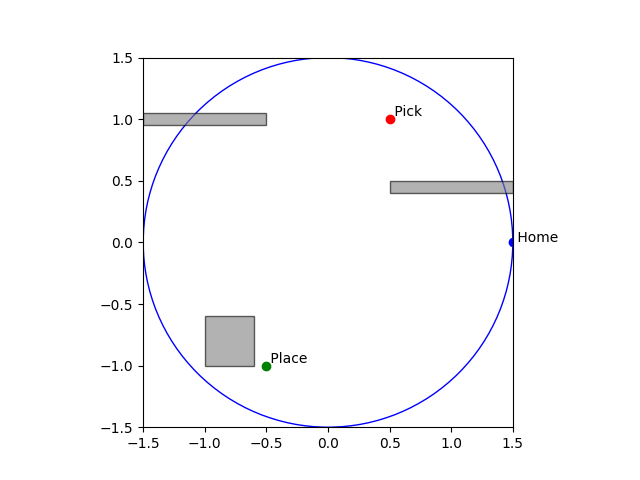

In [2]:
# Source: https://stackoverflow.com/questions/9215658/plot-a-circle-with-matplotlib-pyplot
fig , ax = plt.subplots()
ax.set_xlim(-maxRadius, maxRadius)
ax.set_ylim(-maxRadius, maxRadius)
ax.set_aspect('equal')

maxCircle = plt.Circle((0, 0), maxRadius, color='blue', fill=False)
# minCircle = plt.Circle((0, 0), minRadius, color='red', fill=False)

ax.add_patch(maxCircle)
# ax.add_patch(minCircle)

# --- Add obstacles as filled polygons ---
# tri_patch = Polygon(tri_obstacle, closed=True,
#                     facecolor='gray', edgecolor='black', alpha=0.6)
# tri_patch2 = Polygon(tri_obstacle2, closed=True,
#                     facecolor='gray', edgecolor='black', alpha=0.6)
# quad_patch = Polygon(quad_obstacle, closed=True,
#                      facecolor='orange', edgecolor='black', alpha=0.6)
wall1_patch = Polygon(wall1, closed=True,
                    facecolor='gray', edgecolor='black', alpha=0.6)
wall2_patch = Polygon(wall2, closed=True,
                    facecolor='gray', edgecolor='black', alpha=0.6)
obstacle_patch = Polygon(obstacle, closed=True,
                     facecolor='gray', edgecolor='black', alpha=0.6)

ax.plot(pick[0], pick[1],  'ro')
ax.plot(place[0], place[1], 'go')
ax.plot(home[0], home[1], 'bo')
ax.text(pick[0], pick[1],  ' Pick',  fontsize=10, va='bottom', ha='left')
ax.text(place[0], place[1], ' Place', fontsize=10, va='bottom', ha='left')
ax.text(home[0], home[1], ' Home', fontsize=10)

# ax.add_patch(tri_patch)
# ax.add_patch(tri_patch2)
# ax.add_patch(quad_patch)

ax.add_patch(wall1_patch)
ax.add_patch(wall2_patch)
ax.add_patch(obstacle_patch)

plt.show()

In [3]:
def obstacle_intersection(obstacle: list[tuple[float,float]], link: tuple[tuple[float,float],tuple[float,float]]):
    polygon = shapely.geometry.Polygon(obstacle)
    line = shapely.geometry.LineString(link)

    return line.intersects(polygon)

def generate_configuration_space(obstacles: list[list[tuple[float,float]]], resolution: int  = RESOLUTION, lengths: list[float] = [L1,L2]):
    """ Calculates the movement soace and obstacle space of the specific configuration
    
    Create a matrix of size (resolution X resolution) where the x and y axes are the joints variables
    and assigns a valid or invalid position value to that spot.
    Takes into account the length of the links and the obstacle space to determine if a given input
    of joint variables makes the links pass through any part of the obstacle

    Args:
        resolution (int): controls density of points to consider
        lengths (list[float]): lists the lengths of the links in the configuration
        obstacles ([tuples]): array of obstacles of tuple coordinates, creates the convex hull of all the coordinates in the list

    Returns:
        valid_config_space (matrix): matrix with valid position boolean values and associated joint variables

    """

    valid_config_space = np.zeros((resolution, resolution), dtype=bool)
    theta1 = theta2 = np.linspace(start=0, stop=2*math.pi, num=resolution)

    for i in range(resolution):
        middle_x = math.cos(theta1[i])*lengths[0]
        middle_y = math.sin(theta1[i])*lengths[0]
        link1 = [[0.0,0.0],[middle_x,middle_y]]
        for j in range(resolution):
            ee_x = middle_x + math.cos(theta1[i] + theta2[j])*lengths[1]
            ee_y = middle_y + math.sin(theta1[i] + theta2[j])*lengths[1]
            link2 = [[middle_x,middle_y],[ee_x,ee_y]]
            intersection = False
            for obstacle in obstacles:
                if(obstacle_intersection(obstacle,link1) or obstacle_intersection(obstacle,link2)):
                    intersection = True
            valid_config_space[i][j] = intersection

    return valid_config_space, theta1, theta2

def is_valid(theta1: float, theta2: float, valid_config_space: np.ndarray[tuple[int, int]]):
    theta1_index = math.floor(theta1/(2*math.pi)*RESOLUTION)
    theta2_index = math.floor(theta2/(2*math.pi)*RESOLUTION)
    return not valid_config_space[theta1_index][theta2_index]

def to_index(theta1: float, theta2: float):
    theta1_index = math.floor(theta1/(2*math.pi)*RESOLUTION)
    theta2_index = math.floor(theta2/(2*math.pi)*RESOLUTION)
    return [theta1_index, theta2_index]

# taken from prior work and adapted to allow for values only from [0,2*pi]
# and to include the valid_config_space
def inverse_kinematics(x, y, L1, L2, valid_config_space):
    r2 = x*x + y*y
    c2 = (r2 - L1*L1 - L2*L2) / (2.0*L1*L2)
    s2 = math.sqrt(max(0.0, 1.0 - c2*c2))  # elbow-up only
    theta2 = math.atan2(s2, c2)
    theta1 = math.atan2(y, x) - math.atan2(L2*s2, L1 + L2*c2)
    if theta1 < 0:
        theta1 += 2*math.pi
    if theta2 < 0:
        theta2 += 2*math.pi

    if not is_valid(theta1, theta2, valid_config_space):
        print("Righty solution not valid, finding lefty solution")
        theta2 = -theta2
        theta1 = theta1+2*math.atan2(L2*s2, L1 + L2*c2)
        if theta1 < 0:
            theta1 += 2*math.pi
        if theta2 < 0:
            theta2 += 2*math.pi
    if not is_valid(theta1, theta2, valid_config_space):
        print("Lefty solution also not valid, try something else")

    return theta1, theta2

In [4]:
# taken from guest lecture code
# new fucntions that allows for wrapping around and moving diagonally
def get_neighbors(pos, grid):
    neighbors = []
    for dx, dy in [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(1,-1),(-1,1),(1,1)]:
        nx, ny = (pos[0] + dx)%RESOLUTION, (pos[1] + dy)%RESOLUTION
        if 0 <= nx < grid.shape[0] and 0 <= ny < grid.shape[1] and grid[nx, ny] != 1:
            neighbors.append((nx, ny))
    return neighbors

# Reconstruct path from came_from dictionary
def reconstruct_path(came_from, start, goal):
    current = goal
    path = []
    while current != start:
        path.append(current)
        current = came_from.get(current)
        if current is None:
            return []  # no path found
    path.append(start)
    path.reverse()
    return path


# Dijkstra's Algorithm modified to track visited cells
def dijkstra(grid, start, goal):
    frontier = [(0, start)]
    came_from = {start: None}
    cost_so_far = {start: 0}
    visited = set()
    while frontier:
        _, current = heapq.heappop(frontier)
        visited.add(current)
        if current == goal:
            break
        for neighbor in get_neighbors(current, grid):
            new_cost = cost_so_far[current] + 1
            if neighbor not in cost_so_far or new_cost < cost_so_far[neighbor]:
                cost_so_far[neighbor] = new_cost
                heapq.heappush(frontier, (new_cost, neighbor))
                came_from[neighbor] = current
    path = reconstruct_path(came_from, start, goal)
    return path, visited

def path_finding(grid: np.ndarray, start: list[int, int], end: list[int, int]):
    start_t = (start[0], start[1])
    end_t   = (end[0],   end[1])

    path, _ = dijkstra(grid, start_t, end_t)
    return path

In [5]:
valid_config_space, theta1, theta2 = generate_configuration_space(obstacles)

# calucluate the theta positions of the home, pick, and place coordinates
home_theta = inverse_kinematics(home[0], home[1], L1, L2, valid_config_space)
pick_theta = inverse_kinematics(pick[0], pick[1], L1, L2, valid_config_space)
place_theta = inverse_kinematics(place[0], place[1], L1, L2, valid_config_space)

# create lists for each joint that will store every theta value to visit starting with the home position thetas
full_theta1 = [home_theta[0]]
full_theta2 = [home_theta[1]]

# "index" refers to the integer grid locations in the valid_config_space, needed for the pathfinding algorithmn
# we convert the theta values to index values before applying the pathfinding algorithm
home_index = to_index(home_theta[0], home_theta[1])
pick_index = to_index(pick_theta[0], pick_theta[1])
place_index = to_index(place_theta[0], place_theta[1])

# find the optimal paths using start and end indices
home_to_pick_indices = path_finding(valid_config_space, home_index, pick_index)
pick_to_place_indices = path_finding(valid_config_space, pick_index, place_index)

# create temporary lists for the thetas values to get from home --> pick
theta_path1 = [theta1[i] for (i, j) in home_to_pick_indices]
theta_path2 = [theta2[j] for (i, j) in home_to_pick_indices]

# add those to the running full lists that were created
full_theta1.extend(theta_path1)
full_theta2.extend(theta_path2)

#be sure to add the exact theta value for pick, might not actaully be too necessary if RESOLUTION is high enough
full_theta1.append(pick_theta[0])
full_theta2.append(pick_theta[1])

# repeat for pick --> place
theta_path1 = [theta1[i] for (i, j) in pick_to_place_indices]
theta_path2 = [theta2[j] for (i, j) in pick_to_place_indices]

full_theta1.extend(theta_path1)
full_theta2.extend(theta_path2)

full_theta1.append(place_theta[0])
full_theta2.append(place_theta[1])

Righty solution not valid, finding lefty solution
Righty solution not valid, finding lefty solution


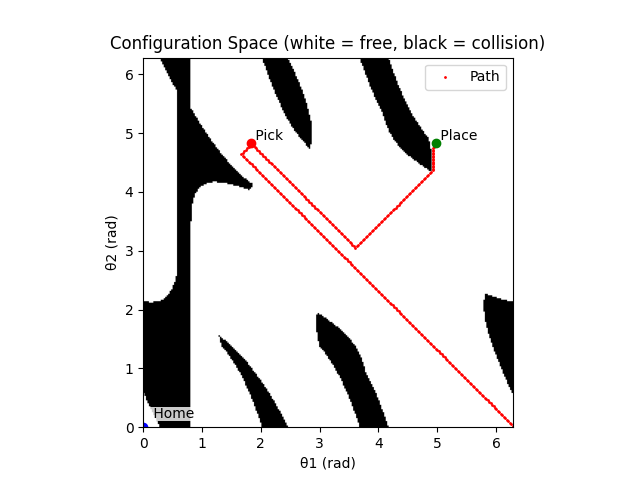

In [13]:
fig, ax = plt.subplots()

####### BELOW IS PARTIALLY FROM CHATGPT ######################

im = ax.imshow(
    valid_config_space.T,          # transpose so axes line up
    origin="lower",
    extent=[0, 2*math.pi, 0, 2*math.pi],
    aspect="equal",
    cmap="Greys"
)

ax.set_xlabel("θ1 (rad)")
ax.set_ylabel("θ2 (rad)")

# Plot the three configurations
ax.plot(pick_theta[0],  pick_theta[1],  'ro')
ax.plot(place_theta[0], place_theta[1], 'go')
ax.plot(home_theta[0],  home_theta[1],  'bo')

# Labels next to the points
ax.text(pick_theta[0],  pick_theta[1],  ' Pick',  fontsize=10, va='bottom', ha='left')
ax.text(place_theta[0], place_theta[1], ' Place', fontsize=10, va='bottom', ha='left')
# ax.text(home_theta[0],  home_theta[1],  ' Home',  fontsize=10, va='bottom', ha='left')
# Define properties for a white box with no border
minimal_props = dict(boxstyle='square', facecolor='white', edgecolor='none', alpha=0.8, pad=0.0)

# Add the text with the minimal text box properties
ax.text(home_theta[0]+0.1, home_theta[1]+0.1, ' Home', fontsize=10, va='bottom', ha='left', bbox=minimal_props)

ax.scatter(full_theta1, full_theta2, s=1, c='r', label='Path')
ax.legend()

ax.set_title("Configuration Space (white = free, black = collision)")

plt.show()

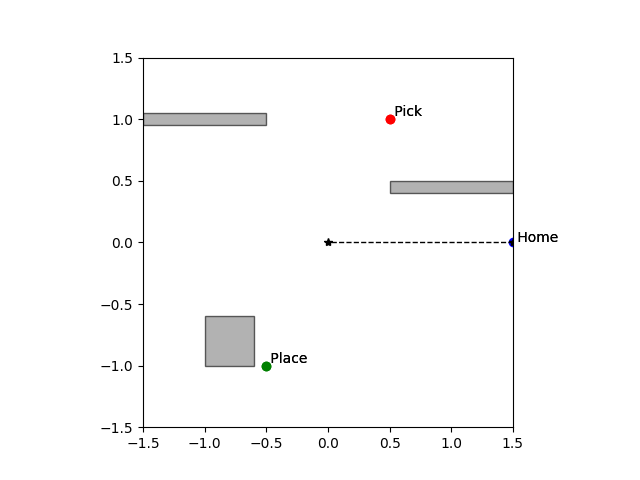

In [8]:
import matplotlib.animation as animation

fig , ax = plt.subplots()
ax.set_xlim(-maxRadius, maxRadius)
ax.set_ylim(-maxRadius, maxRadius)
ax.set_aspect('equal')

# --- Add obstacles as filled polygons ---
wall1_patch = Polygon(wall1, closed=True,
                    facecolor='gray', edgecolor='black', alpha=0.6)
wall2_patch = Polygon(wall2, closed=True,
                    facecolor='gray', edgecolor='black', alpha=0.6)
obstacle_patch = Polygon(obstacle, closed=True,
                     facecolor='gray', edgecolor='black', alpha=0.6)

ax.plot(pick[0], pick[1],  'ro')
ax.plot(place[0], place[1], 'go')
ax.plot(home[0], home[1], 'bo')
ax.text(pick[0], pick[1],  ' Pick',  fontsize=10, va='bottom', ha='left')
ax.text(place[0], place[1], ' Place', fontsize=10, va='bottom', ha='left')
ax.text(home[0], home[1], ' Home', fontsize=10)

ax.add_patch(wall1_patch)
ax.add_patch(wall2_patch)
ax.add_patch(obstacle_patch)

# empty arrays to fill with link positions for animation
middle_x = []
middle_y = []
ee_x = []
ee_y = []

# caluculating middle joint positions from thetas of joint 1
for theta in full_theta1:
  middle_x.append(math.cos(theta)*L1)
  middle_y.append(math.sin(theta)*L1)

# caluculating EE positions from thetas of both joints
for i, theta in enumerate(full_theta2):
  ee_x.append(middle_x[i] + math.cos((theta+full_theta1[i]))*L2)
  ee_y.append(middle_y[i] + math.sin((theta+full_theta1[i]))*L2)

# calculating "forward kinematic" of pick and place positions and plotting them
pick_x = math.cos(pick_theta[0])*L1 + math.cos((pick_theta[0]+pick_theta[1]))*L2
pick_y = math.sin(pick_theta[0])*L1 + math.sin((pick_theta[0]+pick_theta[1]))*L2
place_x = math.cos(place_theta[0])*L1 + math.cos((place_theta[0]+place_theta[1]))*L2
place_y = math.sin(place_theta[0])*L1 + math.sin((place_theta[0]+place_theta[1]))*L2
home_x = L2 + L1
home_y = 0.0

ax.plot(pick_x, pick_y,  'ro')
ax.plot(place_x, place_y, 'go')
ax.plot([home_x,0],[0,home_y], '*--k', lw=1)
ax.text(pick_x,  pick_y,  ' Pick',  fontsize=10, va='bottom', ha='left')
ax.text(place_x, place_y, ' Place', fontsize=10, va='bottom', ha='left')
ax.text(home_x, home_y, ' Home', fontsize=10)

# code below taken from PA2 assignment
(l1_line,) = ax.plot([], [], lw=3)
(l2_line,) = ax.plot([], [], lw=3)
theta1_text = ax.text(0.0,0.0, '')
theta2_text = ax.text(0.0,0.0, '')


def update(frame):
    # for each frame, update the data stored on each artist.
    x_base = 0.0
    y_base = 0.0

    x_middle = middle_x[frame]
    y_middle = middle_y[frame]

    x_ee = ee_x[frame]
    y_ee = ee_y[frame]

    # update the scatter plot:
    l1_line.set_data([x_base, x_middle], [y_base, y_middle])
    l2_line.set_data([x_middle, x_ee], [y_middle, y_ee])

    return l1_line, l2_line

# interval in milliseconds, defined by the clock so the animation is in "real-time"
ani = animation.FuncAnimation(fig=fig, func=update, frames=len(ee_y), interval=30)
plt.show()
ani.save("test.mp4")